# Kaleb Kinder

## Predicting Human Memory Performance

### Summary

This project uses data from my dissertation project (see https://trace.tennessee.edu/utk_graddiss/8126/, Experiment 1)

Data were collected by recruiting 36 participants, who performed a **memory task with mouse-tracking** in-person.

Participants performed a memory task where they were shown either 2, 3, 4, or 5 objects containing different colors. After a brief delay, participants responded with a mouse-cursor, clicking the upper-left or upper-right button to state whether one of the colors changed or if they all remained the same. The outcome variable is whether they **Rememember or Forgot** the objects in memory. See the link above for more details.

**Example memory trial:** 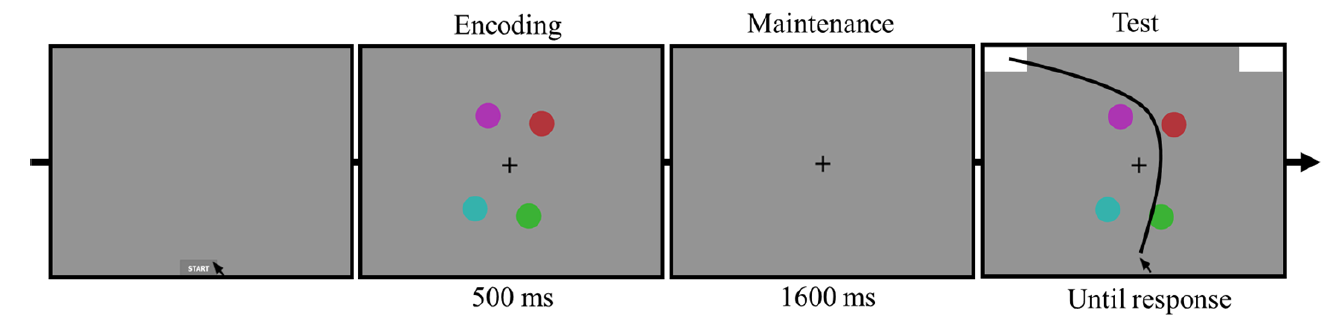

Here, the correct answer was selected (upper-left box = same) because all the colors stayed the same. In this instance, the participant remembered and stored 4 objects in memory. 


#### **Goal**: Predict human memory performance based on relevant features



#### Database Schema

Number of attributes: 9800 rows and 4 columns 

Outcome Variable: 

* Memory Performance - Remembered or Forgotten

Feature Information: 

* Memory Storage - The number of objects held in memory, either 2,3,4 or 5
* Speed - Amount of time to click a response (in milliseconds)
* Initiate Move Time - Time taken to begin moving the mouse-cursor (in milliseconds)

These features were obtained using the MouseTracker software (http://www.mousetracker.org/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# 1. Data Acquisition

In [2]:
#Define relevant features to explore
column_subset = [
    'Memory Storage',
    'Memory Performance',
    'Speed',
    'Start Move Time'
]



In [3]:
df=pd.read_csv('DissMemoryData.csv',usecols=column_subset)

In [4]:
df.head()

,Memory Storage,Memory Performance,Start Move Time,Speed
0,ss3,Remembered,670,6936
1,ss3,Remembered,729,1263
2,ss4,Remembered,419,2219
3,ss2,Remembered,732,1716
4,ss2,Remembered,247,1362


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Memory Storage      9800 non-null   object
 1   Memory Performance  9800 non-null   object
 2   Start Move Time     9800 non-null   int64 
 3   Speed               9800 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 306.4+ KB


In [6]:
df.describe()

,Start Move Time,Speed
count,9800.000000,9800.000000
mean,212.600306,1330.969694
std,183.352797,485.028347
min,24.000000,627.000000
25%,30.000000,1041.000000
50%,201.000000,1221.000000
75%,359.000000,1487.000000
max,1404.000000,9166.000000


# 2. Data Cleaning

**2.1 Missing Data**

In [7]:
# Check for the percentage of missing values across features

df.isnull().sum()

#no null values

Memory Storage        0
Memory Performance    0
Start Move Time       0
Speed                 0
dtype: int64

# 3. EDA
**3.1 Check Target Class Balance**

In [8]:
df['Memory Performance'].value_counts()
#The target classes are imbalanced, which could influence model predictions later

Memory Performance
Remembered    8936
Forgotten      864
Name: count, dtype: int64

**3.2 Analyze Numerical Features**

<Axes: xlabel='Speed'>

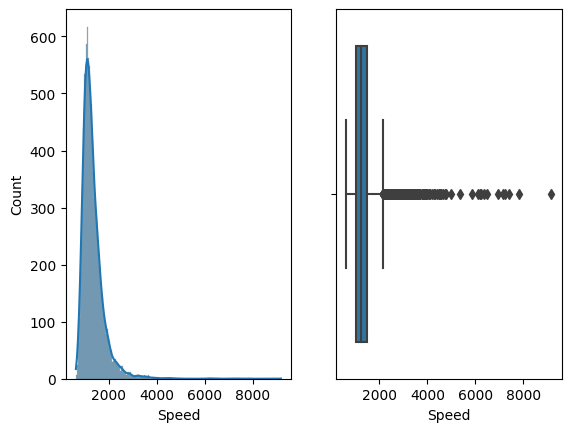

In [9]:
#Explore Speed feature

fig, ax = plt.subplots(1, 2)

sns.histplot(data=df,x='Speed',kde=True,ax=ax[0])
#Speed features is normally distributed

sns.boxplot(data=df,x='Speed',ax=ax[1])

#Longer speed time typically reflects participants being off task (domain knowledge), so I will remove those outliers in this case

<Axes: xlabel='Start Move Time'>

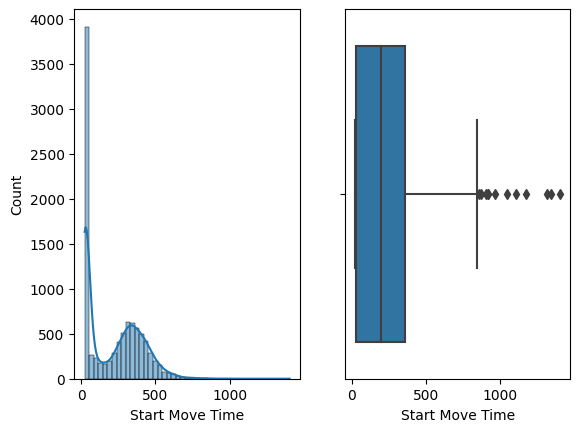

In [10]:
#Explore Start Move Time Area feature

fig, ax = plt.subplots(1, 2)

sns.histplot(data=df,x='Start Move Time',kde=True,ax=ax[0])

sns.boxplot(data=df,x='Start Move Time',ax=ax[1])

#Higher start move times typically reflects participants off task at the start of the memory trial

**3.3 Remove Numerical Feature Outliers**

In [11]:
from scipy import stats

In [12]:
# Remove all rows where speed,curvature, or start move time values are greater than two standard deviations above the mean 
df = df[(np.abs(stats.zscore(df['Speed'])) < 2)]
df = df[(np.abs(stats.zscore(df['Start Move Time'])) < 2)]

df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

**3.4 Explore Feature Relationships**

In [13]:
#Explore if there is any multicollinearity among features

df.corr(numeric_only=True)

#numerical features are not correlated

,Start Move Time,Speed
Start Move Time,1.000000,0.023528
Speed,0.023528,1.000000


Text(0.5, 1.0, 'Speed in relation to Memory Storage')

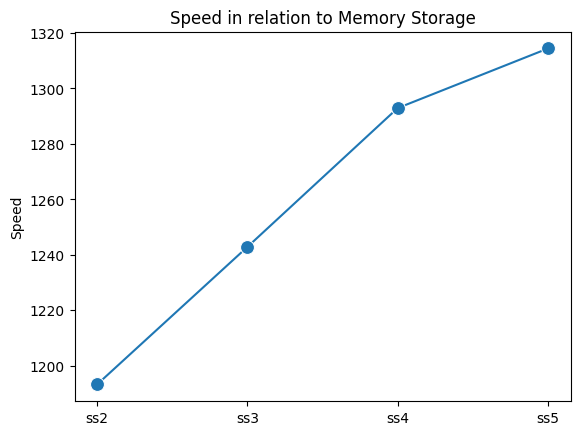

In [14]:
#Explore relationship between numerical and categorical features

#Create categorical df where mem storage is ordered from smallest to largest number of objects in memory
mem_storage = pd.Categorical(df['Memory Storage'],categories=['ss2','ss3','ss4','ss5'],ordered=True)

sns.lineplot(x=mem_storage,y=df['Speed'],errorbar=None, marker='o',markersize=10)
plt.title('Speed in relation to Memory Storage')


#Speed appears to decrease (takes longer) as the number of items in memory increases

Text(0.5, 1.0, 'Start Move Time in relation to Memory Storage')

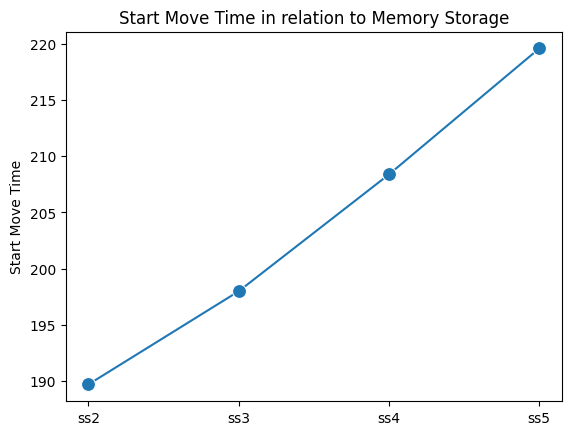

In [15]:
sns.lineplot(x=mem_storage,y=df['Start Move Time'],errorbar=None, marker='o',markersize=10)
plt.title('Start Move Time in relation to Memory Storage')
#Start Move Time 

#Start move time also appears to increase as the number of items in memory increases

**3.5 Explore relationship between features and target outcome**

<Axes: ylabel='count'>

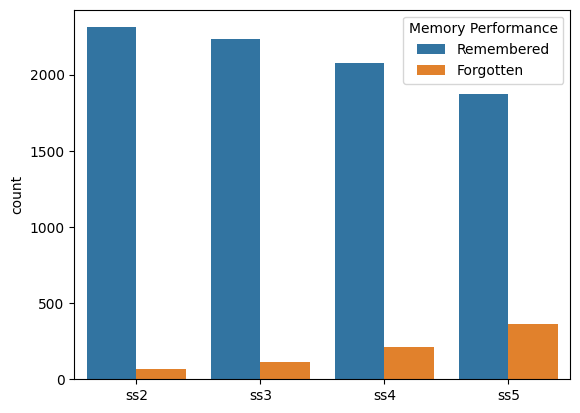

In [16]:
#Explore relationship between features and target outcome

#sns.histplot(data=df,x=mem_storage,hue='Memory Performance',stat='percent')

sns.countplot(x=mem_storage,hue=df['Memory Performance'])


#Memory performance gets worse as more items are added to memory

# 4. Data Preprocessing

**4.1 Encode categorical features using dummy coding**

In [17]:
category_features=['Memory Storage'] 
df = pd.get_dummies(df,columns=category_features,dtype=float)
category_features=['Memory Performance']
df = pd.get_dummies(df,columns=category_features,dtype=float,drop_first=True)

df.head()

,Start Move Time,Speed,Memory Storage_ss2,Memory Storage_ss3,Memory Storage_ss4,Memory Storage_ss5,Memory Performance_Remembered
0,419,2219,0.0,0.0,1.0,0.0,1.0
1,247,1362,1.0,0.0,0.0,0.0,1.0
2,30,1688,0.0,1.0,0.0,0.0,1.0
3,560,1120,0.0,1.0,0.0,0.0,1.0
4,28,1350,0.0,0.0,0.0,1.0,0.0


# 5. Train the Random Forest Model to predict Memory Storage

**5.1 Use sklearn to split the data into a training dataset and a test dataset**

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X=df.drop(['Memory Performance_Remembered'],axis=1) #drop outcome variable and non features
y=df['Memory Performance_Remembered'] #define outcome variable as Memory Performance (remembered or forgotten)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) #30% of data randomly assigned to test dataset

In [20]:
from sklearn.ensemble import RandomForestClassifier #import the random forest model

#Fit model
rfc = RandomForestClassifier(n_estimators=600,class_weight='balanced')
rfc.fit(X_train,y_train) 

RandomForestClassifier(class_weight='balanced', n_estimators=600)

# 6. Evaluating RF Model Predictions

In [21]:
predictions = rfc.predict(X_test)

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [23]:
acc = accuracy_score(y_test, predictions)
print("Memory Performance Prediction Accuracy: "+"{:.0%}".format(acc));

#RF Model performed at high accuracy for predicting memory performance

Memory Performance Prediction Accuracy: 89%


**6.1 Evaluate and Visualize Feature Importance**

In [24]:
#Calcuate SHAP values to understand the contributions of each feature
import shap as sh

explainer = sh.TreeExplainer(rfc,X_test)

# Calculate SHAP values for the testing data
shap_values = explainer.shap_values(X_test)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
100%|===================| 5536/5548 [07:13<00:00]        

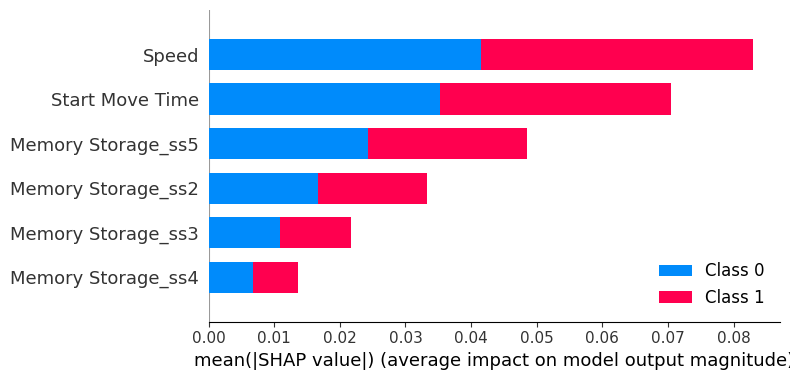

In [25]:
#Create summary plot to visualize the impact of each feature on memory performance

sh.summary_plot(shap_values, X_test)

#Overall, Speed was the most important feature for predicting memory performance, followed by move time. 

100%|===================| 5547/5548 [07:30<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


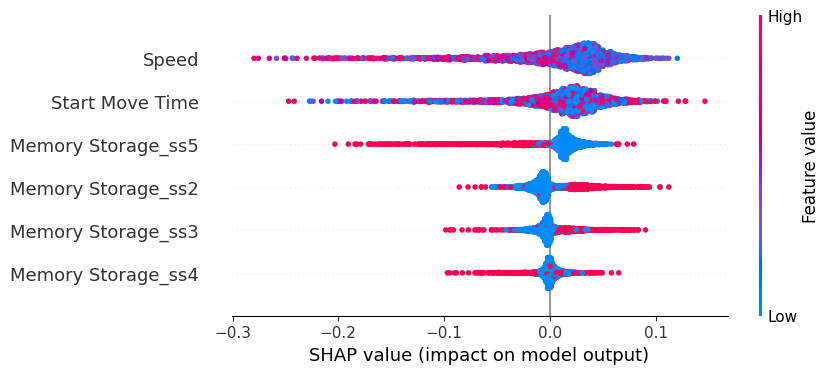

In [26]:
# Create a beeswarm plot
shap_values= explainer(X_test)
sh.plots.beeswarm(shap_values[:,:,1]) #Remembered Shap value beeswarm plot


# Observation: When Speed was fast (lower values), model was more likely to predict Remember
#When 5 objects were stored in memory, model was more likely to predict forgot

# 7. Compare XGBoost to RF

In [27]:
#Import XGBoostlibrary
import xgboost as xgb
classifier = xgb.XGBClassifier()

#Fit the model to training data
classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [28]:
#Evaluate model predictions at a glance
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)
#XGBoost performed similarly to RF model

0.9051910598413843


# 8. Create Dashboard

In [29]:
#import dashboard library
from explainerdashboard import InlineExplainer,ClassifierExplainer


#create an explainer object
explainer = ClassifierExplainer(rfc, X_test, y_test)
ie = InlineExplainer(explainer)


Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [30]:
#Explore impact of features on predicted outcome Remember

ie.shap.summary()

In [31]:
ie.importances()

Calculating shap values...


In [32]:
#Visuzalize model metrics including accuracy, precision, recall, and the confusion matrix
ie.tab.modelsummary()

## What if Speed was 800ms, start move time was 200ms, and 5 objects were in memory? What would the predicted outcome be? 

### Prediction: 86.0% Probability that memory would be Remembered (label 1). 
### Under Contributions Plot, we can see that the relatively fast Speed (800ms) contributed most (30.83%) to predicting Remember, 
### Whereas Memory Storage = 5 contributed to Forgot (-7.59%) on this specific prediction

In [33]:
ie.tab.whatif()

# 9. Conclusions

* Model predicted (RF and XGBoost) memory performance overall at 90% accuracy

* The Feature Speed was the most important for predicting memory performance. When speed was faster, the model predicted better memory performance (remembered outcome)

* The more items stored in memory, the model predicted worse memory performance